## Customer Lifetime Value Prediction

In [76]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [22]:
# Load data
customer = pd.read_csv('RawData/olist_customers_dataset.csv')
order = pd.read_csv('RawData/olist_orders_dataset.csv')
item = pd.read_csv('RawData/olist_order_items_dataset.csv')
review = pd.read_csv('RawData/olist_order_reviews_dataset.csv')
product = pd.read_csv('RawData/olist_products_dataset.csv')
category = pd.read_csv('RawData/product_category_name_translation.csv')
payment = pd.read_csv('RawData/olist_order_payments_dataset.csv')

In [23]:
# Merge data
df = customer.merge(order, how='inner', on='customer_id')
df = df.merge(item, how='inner', on='order_id')
df = df.merge(payment, how='inner', on='order_id')
df = df.merge(product, how='inner', on='product_id')
df = df.merge(review, how='inner', on='order_id')
df = df.merge(category, how='inner', on='product_category_name')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116581 entries, 0 to 116580
Data columns (total 37 columns):
customer_id                      116581 non-null object
customer_unique_id               116581 non-null object
customer_zip_code_prefix         116581 non-null int64
customer_city                    116581 non-null object
customer_state                   116581 non-null object
order_id                         116581 non-null object
order_status                     116581 non-null object
order_purchase_timestamp         116581 non-null object
order_approved_at                116567 non-null object
order_delivered_carrier_date     115368 non-null object
order_delivered_customer_date    114066 non-null object
order_estimated_delivery_date    116581 non-null object
order_item_id                    116581 non-null int64
product_id                       116581 non-null object
seller_id                        116581 non-null object
shipping_limit_date              116581 non-null ob

In [24]:
payment.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [25]:
# Select features
df = df[['customer_unique_id', 'order_purchase_timestamp','order_id', 
         'order_item_id', 'payment_value','order_status']]

# Only keep delivered order for customer clustering
df = df.loc[df.order_status=='delivered']
df.drop(["order_status"], axis = 1, inplace = True) 
df.head()

,customer_unique_id,order_purchase_timestamp,order_id,order_item_id,payment_value
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,00e7ee1b050b8499577073aeb2a297a1,1,146.87
1,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,c1d2b34febe9cd269e378117d6681172,1,275.79
2,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,c1d2b34febe9cd269e378117d6681172,2,275.79
3,3c799d181c34d51f6d44bbbc563024db,2017-05-07 20:11:26,b1a5d5365d330d10485e0203d54ab9e8,1,140.61
4,23397e992b09769faf5e66f9e171a241,2018-02-03 19:45:40,2e604b3614664aa66867856dba7e61b7,1,137.58


In [26]:
# Change timestamp to datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_date'] = df.order_purchase_timestamp.dt.date 
df['order_date'] = pd.to_datetime(df['order_date'])
df.drop(["order_purchase_timestamp"], axis = 1, inplace = True) 
df.head()

,customer_unique_id,order_id,order_item_id,payment_value,order_date
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,1,146.87,2017-05-16
1,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,1,275.79,2017-11-09
2,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,2,275.79,2017-11-09
3,3c799d181c34d51f6d44bbbc563024db,b1a5d5365d330d10485e0203d54ab9e8,1,140.61,2017-05-07
4,23397e992b09769faf5e66f9e171a241,2e604b3614664aa66867856dba7e61b7,1,137.58,2018-02-03


### Calculation of certain features
- No. of days between the present date and the date of last purchase from each customer.
- No. of orders placed by each customer
- No. of items bought by each customer 
- Sum of purchase payment for each customer.

In [30]:
df_group=df.groupby('customer_unique_id').agg({'order_date': lambda date: (date.max() - date.min()).days,
                                               'order_id': lambda num: len(num),
                                               'order_item_id': lambda quant: quant.sum(),
                                               'payment_value': lambda price: price.sum()})

In [31]:
# Change column names
df_group.columns=['num_days','num_transactions','num_units','spent_money']
df_group.head()

,num_days,num_transactions,num_units,spent_money
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19
0000f46a3911fa3c0805444483337064,0,1,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89


### Calculate CLTV using following formula:
- CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.
- Customer Value = Average Order Value * Purchase Frequency

In [52]:
# Calculate Average Order Value
df_group['avg_order_value']=df_group['spent_money']/df_group['num_transactions']
df_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value,cust_value
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90,141.90,7.0950,206.972882,1468.472601,206.972882
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19,27.19,1.3595,39.658863,53.916224,39.658863
0000f46a3911fa3c0805444483337064,0,1,1,86.22,86.22,4.3110,125.758999,542.147044,125.758999
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62,43.62,2.1810,63.623377,138.762584,63.623377
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89,196.89,9.8445,287.180344,2827.146897,287.180344


In [53]:
# Calculate Purchase frequency
purchase_frequency=sum(df_group['num_transactions'])/df_group.shape[0]

In [54]:
# Calculate Repeat Rate and Churn Rate
repeat_rate=df_group[df_group.num_transactions > 1].shape[0]/df_group.shape[0]
churn_rate=1-repeat_rate

In [55]:
purchase_frequency,repeat_rate,churn_rate

(1.2388084015725798, 0.15067660027368102, 0.849323399726319)

In [56]:
# Calculate Profit margin: assume approx 5% profit on the total sales
df_group['profit_margin']=df_group['spent_money']*0.05
df_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value,cust_value
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90,141.90,7.0950,206.972882,1468.472601,206.972882
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19,27.19,1.3595,39.658863,53.916224,39.658863
0000f46a3911fa3c0805444483337064,0,1,1,86.22,86.22,4.3110,125.758999,542.147044,125.758999
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62,43.62,2.1810,63.623377,138.762584,63.623377
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89,196.89,9.8445,287.180344,2827.146897,287.180344


In [57]:
# Calcualte Customer Value
df_group['cust_value']=(df_group['avg_order_value']*purchase_frequency)/churn_rate

In [59]:
# Calcualte Customer Lifetime Value
df_group['cust_lifetime_value']=df_group['cust_value']*df_group['profit_margin']
df_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value,cust_value
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90,141.90,7.0950,206.972882,1468.472601,206.972882
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19,27.19,1.3595,39.658863,53.916224,39.658863
0000f46a3911fa3c0805444483337064,0,1,1,86.22,86.22,4.3110,125.758999,542.147044,125.758999
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62,43.62,2.1810,63.623377,138.762584,63.623377
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89,196.89,9.8445,287.180344,2827.146897,287.180344


### Predict CLV using Linear Regression Model

In [61]:
# Extract month and year from order_date
df['month_yr'] = df['order_date'].apply(lambda x: x.strftime('%b-%Y'))
df.head()

,customer_unique_id,order_id,order_item_id,payment_value,order_date,month_yr
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,1,146.87,2017-05-16,May-2017
1,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,1,275.79,2017-11-09,Nov-2017
2,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,2,275.79,2017-11-09,Nov-2017
3,3c799d181c34d51f6d44bbbc563024db,b1a5d5365d330d10485e0203d54ab9e8,1,140.61,2017-05-07,May-2017
4,23397e992b09769faf5e66f9e171a241,2e604b3614664aa66867856dba7e61b7,1,137.58,2018-02-03,Feb-2018


In [63]:
# Create pivot table for sales
sale = df.pivot_table(index=['customer_unique_id'],
                      columns=['month_yr'],
                      values='payment_value',
                      aggfunc='sum',fill_value=0).reset_index()
sale.head()

month_yr,customer_unique_id,Apr-2017,Apr-2018,Aug-2017,Aug-2018,Dec-2016,Dec-2017,Feb-2017,Feb-2018,Jan-2017,...,Jun-2017,Jun-2018,Mar-2017,Mar-2018,May-2017,May-2018,Nov-2017,Oct-2016,Oct-2017,Sep-2017
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,141.90,0.00,0.0,0.00,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,27.19,0.00,0.0,0.00,0.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,86.22,0.0,0.0,0.00,0.00,0.0,0.00,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,43.62,0.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,196.89,0.0,0.00,0.0


In [67]:
# Sum all the monthly sales
sale['cust_value']=sale.iloc[:,2:].sum(axis=1)
sale.columns

Index(['customer_unique_id', 'Apr-2017', 'Apr-2018', 'Aug-2017', 'Aug-2018',
       'Dec-2016', 'Dec-2017', 'Feb-2017', 'Feb-2018', 'Jan-2017', 'Jan-2018',
       'Jul-2017', 'Jul-2018', 'Jun-2017', 'Jun-2018', 'Mar-2017', 'Mar-2018',
       'May-2017', 'May-2018', 'Nov-2017', 'Oct-2016', 'Oct-2017', 'Sep-2017',
       'cust_value'],
      dtype='object', name='month_yr')

In [68]:
# Select the latest 6 month as independent variable
X=sale[['Aug-2018','Jul-2018', 'Jun-2018','May-2018','Apr-2018','Mar-2018']]
y=sale[['cust_value']]

In [73]:
# Split Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [75]:
# Fit Linear Regression Model
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

print(linreg.intercept_)
print(linreg.coef_)

[501.28194193]
[[3.71372004 3.76633991 3.67767039 3.58895819 3.88430342 3.63780292]]


### Evaluate the linear model

In [79]:
# Compute the evaluation matrics
print("R-Square:", metrics.r2_score(y_test, y_pred))
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))
print("MSE",metrics.mean_squared_error(y_test, y_pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-Square: 0.10590005786727785
MAE: 539.7284637159894
MSE 10385821.023280628
RMSE: 3222.703992500805


**Reference:** https://www.datacamp.com/community/tutorials/customer-life-time-value

### Predict CLV using other 3 models

#### Model 1: Analytics Aggregate CLV
Assume a constant rate of spend and churn for all customers

In [83]:
orders = pd.DataFrame(df, columns = ["customer_unique_id", "order_date", "order_item_id", "payment_value"])
orders = orders[orders["payment_value"] > 0]
orders.head()

,customer_unique_id,order_date,order_item_id,payment_value
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16,1,146.87
1,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09,1,275.79
2,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09,2,275.79
3,3c799d181c34d51f6d44bbbc563024db,2017-05-07,1,140.61
4,23397e992b09769faf5e66f9e171a241,2018-02-03,1,137.58


In [84]:
from datetime import timedelta
from numpy import ceil, maximum

group_by_customer = orders.groupby(["customer_unique_id"], as_index = False)
customers = group_by_customer["order_date"].agg(lambda x: (x.max() - x.min()))

# Calculate "customer age" using month as the measurement
customers["age"] = maximum(customers["order_date"].apply(lambda x: ceil(x.days/30)), 1.0)
customers = customers.drop(columns = "order_date")
customers.head()

,customer_unique_id,age
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0
2,0000f46a3911fa3c0805444483337064,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,1.0
4,0004aac84e0df4da2b147fca70cf8255,1.0


In [86]:
# Assuming a customer will never return (has churned) after 12 weeks of inactivity

twelve_weeks = timedelta(weeks = 12)
cutoff_date = orders["order_date"].max()

dead = group_by_customer["order_date"].max()["order_date"].apply(lambda x: (cutoff_date - x) > twelve_weeks)

churn = dead.sum() / customers["age"].sum()
spend = orders["payment_value"].sum() / customers["age"].sum()

clv_aa = spend/churn 
print(clv_aa)

262.887069526449


**Result:** The analytic aggregate CLV model predicts customer CLV to be $262.89 for each customer.

#### Model 2: Analytic Cohort-based CLV

Group customers by their cohorts, under the assumption that customers within a cohort spend similarly. Calculate CLV for each cohort.

In [89]:
customers_ac = customers.merge(group_by_customer["payment_value"].sum(), on = "customer_unique_id")
customers_ac["clv"] = customers_ac["payment_value"] / customers_ac["age"] / churn
customers_ac.head()

,customer_unique_id,age,payment_value,clv
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0,141.90,188.426770
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,27.19,36.105172
2,0000f46a3911fa3c0805444483337064,1.0,86.22,114.490177
3,0000f6ccb0745a6a4b88665a16c9f078,1.0,43.62,57.922310
4,0004aac84e0df4da2b147fca70cf8255,1.0,196.89,261.447123


In [90]:
clv_ac = customers_ac["clv"]
print(clv_ac.mean())
print(clv_ac.median())

276.0670071552157
146.62497516434377


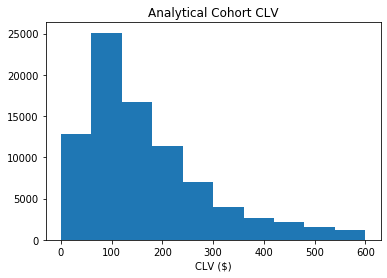

In [92]:
from matplotlib import pyplot as plt

plt.hist(clv_ac, range = (0, 600))
plt.title("Analytical Cohort CLV")
plt.xlabel("CLV ($)")
plt.savefig("clv_cohort_hist.png", dpi = 300, bbox_inches = "tight")
plt.show()

**Observations:**
- A histogram of CLV predictions shows that most fall between USD 5 and USD 600, and the mostly likely prediction is a bit more than USD100. 
- Finally, the mean is USD 276.07 and the median is USD 146.62.

#### Model 3: Predictive CLV using statistical models

Assume individuals differ in churn as well as spend. Calculate the recency, frequency and age for each customer.

In [93]:
from lifetimes.utils import summary_data_from_transaction_data
 
data = summary_data_from_transaction_data(
    orders, 'customer_unique_id', 'order_date', 
    monetary_value_col='payment_value',
    observation_period_end = cutoff_date)
data.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,111.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,114.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,537.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,321.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,288.0,0.0


In [94]:
# Fit a Beta-Geometric model to the data
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 92078 subjects, a: 2.11, alpha: 67.76, b: 0.36, r: 0.02>

Predict the number of transactions expected from each customer over the course of their lifetime.

In [95]:
future_horizon = 10000
data['predicted_purchases'] = bgf.predict(future_horizon, data['frequency'],
                                          data['recency'],data['T'])
data.head()

,frequency,recency,T,monetary_value,predicted_purchases
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,111.0,0.0,0.074461
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,114.0,0.0,0.074143
0000f46a3911fa3c0805444483337064,0.0,0.0,537.0,0.0,0.051593
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,321.0,0.0,0.059746
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,288.0,0.0,0.061406


In [96]:
# Estimate sales revenue for each transaction by fitting spend data to Gamma-Gamma model

from lifetimes import GammaGammaFitter

returning_customers_summary = data[data['frequency'] > 0]

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

transaction_spend = ggf.conditional_expected_average_profit(data['frequency'],
                                                            data['monetary_value']).mean()
print(transaction_spend)

227.67858235385944


According to this model, the expected revenue from each transaction is $227.68.

In [97]:
customers_pm = customers_ac.join(data["predicted_purchases"], on = "customer_unique_id", 
                                 how = "left").drop(columns = "clv")

customers_pm["clv"] = customers_pm.apply(
        lambda x: x["predicted_purchases"] * transaction_spend, axis = 1)
customers_pm.tail()

,customer_unique_id,age,payment_value,predicted_purchases,clv
92073,fffcf5a5ff07b0908bd4e2dbc735a684,1.0,4134.84,0.054540,12.417700
92074,fffea47cd6d3cc0a88bd621562a9d061,1.0,84.58,0.062832,14.305441
92075,ffff371b4d645b6ecea244b27531430a,1.0,112.46,0.050686,11.540050
92076,ffff5962728ec6157033ef9805bacc48,1.0,133.69,0.073624,16.762644
92077,ffffd2657e2aad2907e67c3e9daecbeb,1.0,71.56,0.053267,12.127711


In [98]:
clv_pm = customers_pm["clv"]
print(clv_pm.mean())
print(clv_pm.median())

15.923993680832254
14.965948542293757


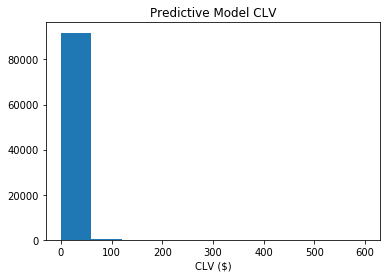

In [99]:
# Plot distribution of clv
plt.hist(clv_pm, range = (0,600))
plt.title("Predictive Model CLV")
plt.xlabel("CLV ($)")
plt.savefig("clv_bgf_hist.png", dpi = 300, bbox_inches = "tight")
plt.show()

Most customers will spend about $50. 